In [5]:
import os
import sys
import tensorflow as tf
import numpy as np
import json
import h5py
import pdb

sys.path.append('ibmHearingAid/multi_gpu')
import pitchnet_evaluate_best
import functions_graph_assembly as fga

import importlib
import util_neurophysiology
importlib.reload(util_neurophysiology)

sys.path.append('/om4/group/mcdermott/user/msaddler/pitchnet_dataset/pitchnetDataset/pitchnetDataset')
import dataset_util

sys.path.append('/om2/user/msaddler/python-packages/msutil')
import util_figures
import util_misc
import util_stimuli

sys.path.append('assets_datasets')
import util_stimuli

import importlib
%matplotlib inline
import matplotlib.pyplot as plt

tf.test.is_gpu_available()


False

In [2]:
# output_directory = '/saved_models/arch_0628/PND_v04_TLAS_classification1'
# output_directory = '/saved_models/arch_0628/PND_v04_JWSS_highpass_v00_classification2'
output_directory = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification2'
# output_directory = '/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification2'
# output_directory = '/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification2'

config_fn = os.path.join(output_directory, 'config.json')
validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')

# tfrecords_regex = '/om/user/msaddler/data_pitchnet/bernox2005/FixedFilter_f0min100_f0max300/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/*.tfrecords'
# tfrecords_regex = '/om/user/msaddler/data_pitchnet/bernox2006/nharm10_f0min100_f0max300_TENlevel40dB_harmlevel50dBSPL/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/*.tfrecords'
tfrecords_regex = '/om/user/msaddler/data_pitchnet/neurophysiology/nharm12_lharm01to24_phase0_f0min080_f0max640_TENlevel10dB_harmlevel45dBSPL/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/*.tfrecords'

with open(config_fn) as f: CONFIG = json.load(f)

ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                             metric_key='f0_label:accuracy',
                                                             maximize=True,
                                                             checkpoint_number_key='step')


Selecting checkpoint 70000 (f0_label:accuracy=0.23932062089443207)


In [3]:
ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
batch_size = 128
bytesList_decoding_dict = {"meanrates": {"dtype": "tf.float32", "shape": [100, 1000]}}
feature_parsing_dict = pitchnet_evaluate_best.get_feature_parsing_dict_from_tfrecords(tfrecords_regex,
                                                                                      bytesList_decoding_dict)

ITERATOR_PARAMS['feature_parsing_dict'] = feature_parsing_dict
# ITERATOR_PARAMS['dataset_filter_params'] = {
#     'phase_mode': 0
# }
N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']


tf.reset_default_graph()

# BUILD TFRECORDS ITERATOR GRAPH
iterator, dataset, _ = fga.build_tfrecords_iterator(tfrecords_regex,
                                                    num_epochs=1, shuffle_flag=False,
                                                    batch_size=batch_size,
                                                    iterator_type='one-shot',
                                                    **ITERATOR_PARAMS)
input_tensor_dict = iterator.get_next()

### BUILD BRAIN NETWORK GRAPH
batch_subbands = input_tensor_dict[ITERATOR_PARAMS['feature_signal_path']]
while len(batch_subbands.shape) < 4: batch_subbands = tf.expand_dims(batch_subbands, axis=-1)
batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)

### START SESSION AND INITIALIZE GRAPH
init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
sess = tf.Session()
sess.run(init_op)

### BUILD SAVER GRAPH TO LOAD CHECKPOINT
brain_var_scope = 'brain_network'
brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
brain_variables =  brain_globals + brain_locals
saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
    sess, brain_variables, output_directory,
    restore_model_path=restore_model_path,
    ckpt_prefix_name=brain_ckpt_prefix_name)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`
min_audible_harm dict_keys(['int64List'])
pin_dBSPL dict_keys(['floatList'])
f0_log2 dict_keys(['floatList'])
low_harm dict_keys(['int64List'])
phase_mode dict_keys(['int64List'])
f0_lognormal dict_keys(['floatList'])
meanrates dict_keys(['bytesList'])
signal dict_keys(['bytesList'])
Ignoring tfrecords_key `signal` (not found in bytesList_decoding_dict)
f0_label dict_keys(['int64List'])
max_audible_harm dict_keys(['int64List'])
f0 dict_keys(['floatList'])
### Files found: 20
/om/user/msaddler/data_pitchnet/neurophysiology/nharm12_lharm01to24_phase0_f0min080_f0max640_TENlevel10dB_harmlevel45dBSPL/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/bez2018meanrates_000000-001382.tfrecords 
...
 /om/user/msaddler/data_pitchnet/neurophysiology/nharm12_lharm01to24_phase0_f0min080_f0max640_TENlevel10dB_harmlevel45dBSPL/sr20000_cf100_species002_spont070_BW10eN1_IHC3000Hz_IHC7order/bez2018meanrates_0

In [ ]:
output_directory_list = [
    ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_AN_BW10eN1_IHC3000Hz_classification0', 'Natural'),
#     ('/saved_models/models_sr20000/arch_0302/PND_v08_TLAS_snr_neg10pos10_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0', 'Natural (HPv00)'),
#     ('/saved_models/models_sr20000/arch_0302/PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0', 'Synthetic (HPv00)'),
]

model_dict_list = []

for (output_directory, model_name) in output_directory_list:
    config_fn = os.path.join(output_directory, 'config.json')
    validation_metrics_fn = os.path.join(output_directory, 'validation_metrics.json')
    with open(config_fn) as f: CONFIG = json.load(f)
    ckpt_num = pitchnet_evaluate_best.get_best_checkpoint_number(validation_metrics_fn,
                                                                 metric_key='f0_label:accuracy',
                                                                 maximize=True,
                                                                 checkpoint_number_key='step')
    
    ITERATOR_PARAMS = CONFIG['ITERATOR_PARAMS']
    N_CLASSES_DICT = CONFIG['N_CLASSES_DICT']
    BRAIN_PARAMS = CONFIG['BRAIN_PARAMS']

    tf.reset_default_graph()
    batch_subbands = tf.placeholder(tf.float32, shape=[None, 100, 1000, 1])
    batch_out_dict, brain_container = fga.build_brain_graph(batch_subbands, N_CLASSES_DICT, **BRAIN_PARAMS)
    init_op = tf.group(tf.global_variables_initializer(), tf.local_variables_initializer())
    sess = tf.Session()
    sess.run(init_op)
    brain_var_scope = 'brain_network'
    brain_ckpt_prefix_name = BRAIN_PARAMS.get('save_ckpt_path', 'brain_model.ckpt')
    restore_model_path = os.path.join(output_directory, brain_ckpt_prefix_name + '-{}'.format(ckpt_num))
    brain_globals = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=brain_var_scope)
    brain_locals = tf.get_collection(tf.GraphKeys.LOCAL_VARIABLES, scope=brain_var_scope)
    brain_variables =  brain_globals + brain_locals
    saver_brain_net, out_ckpt_loc_brain_net, brain_net_ckpt = fga.build_saver(
        sess, brain_variables, output_directory,
        restore_model_path=restore_model_path,
        ckpt_prefix_name=brain_ckpt_prefix_name)
    
    model_dict = {'model_name': model_name}
    tf_var = brain_variables[0] # conv0 filter kernels
    tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
    tf_var_name = tf_var.name
    model_dict['vars'] = {tf_var_name: tf_var_value}
    model_dict_list.append(model_dict)


In [ ]:
sr = 20000

fig, ax = plt.subplots(nrows=1,
                       ncols=1,
                       figsize=(12, 3),
                       sharex=True,
                       sharey=True)

for model_dict in model_dict_list:    
    model_name = model_dict['model_name']
    kernels = model_dict['vars']['brain_network/conv_0/kernel:0']
    list_pxx = []
    for idx in range(kernels.shape[0]):
        fxx, pxx = util_stimuli.power_spectrum(kernels[idx], sr)
        list_pxx.append(pxx)
    kernels_pxx = np.stack(list_pxx)
    kernels_pxx_mean = np.mean(kernels_pxx, axis=0)
    kernels_pxx_std = np.std(kernels_pxx, axis=0)
    ax.plot(fxx, kernels_pxx_mean, label=model_name, lw=2)

ax = util_figures.format_axes(ax,
                                str_xlabel='Frequency (Hz)',
                                str_ylabel='Mean power spectrum (dB)',
                                fontsize_labels=12,
                                fontsize_ticks=12,
                                fontweight_labels=None,
                                xscale='linear',
                                yscale='linear',
                                xlimits=None,
                                ylimits=None,
                                xticks=None,
                                yticks=None,
                                xticks_minor=None,
                                yticks_minor=None,
                                xticklabels=None,
                                yticklabels=None,
                                spines_to_hide=[],
                                major_tick_params_kwargs_update={},
                                minor_tick_params_kwargs_update={})
ax.set_title('conv0 kernel mean power spectra', fontsize=12)
ax.legend()
plt.show()


In [ ]:
tf_var = brain_variables[0] # conv0 filter kernels
tf_var_value = np.transpose(np.squeeze(sess.run(tf_var)))
tf_var_name = tf_var.name

sr = 20000
print(tf_var_name)

N = tf_var_value.shape[0]

NCOLS = 8
NROWS = int(np.ceil(N / NCOLS))

fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    t = 1e3 * np.arange(0, len(x)) / sr
    ax[idx].plot(t, x, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'Pa'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Time (ms)'
    ax[idx] = util_figures.format_axes(ax[idx],
                                        str_xlabel=str_xlabel,
                                        str_ylabel=str_ylabel,
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=None,
                                        ylimits=None,
                                        xticks=None,
                                        yticks=None,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=None,
                                        yticklabels=None,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


fig, ax = plt.subplots(nrows=NROWS,
                       ncols=NCOLS,
                       figsize=(2.5*NCOLS, 2.5*NROWS),
                       sharex=True,
                       sharey=True)
ax = ax.flatten()
for idx in range(N):
    x = tf_var_value[idx]
    fxx, pxx = util_stimuli.power_spectrum(x, sr)
    ax[idx].plot(fxx, pxx, 'k-', lw=0.5)
    (str_xlabel, str_ylabel) = (None, None)
    if idx % NCOLS == 0:
        str_ylabel = 'PSD (dB/Hz SPL)'
    if idx // NCOLS == NROWS - 1:
        str_xlabel = 'Frequency (Hz)'
    ax[idx] = util_figures.format_axes(ax[idx],
                                        str_xlabel=str_xlabel,
                                        str_ylabel=str_ylabel,
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=[0, 10000],
                                        ylimits=None,
                                        xticks=None,
                                        yticks=None,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=None,
                                        yticklabels=None,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})
plt.tight_layout()
plt.show()


In [4]:
### EVALUATION ROUTINE + STORE ACTIVATIONS
tensors_to_evaluate = {}

metadata_keys = ['f0', 'f0_label', 'low_harm', 'phase_mode']
for key in metadata_keys:
    tensors_to_evaluate[key] = input_tensor_dict[key]

mean_axis = [1, 2]
for key in brain_container.keys():
    if 'relu' in key:
        activations = brain_container[key]
        if len(activations.shape) == 4:
            tensors_to_evaluate[key] = tf.reduce_mean(activations, axis=mean_axis)
        else:
            tensors_to_evaluate[key] = activations

output_dict = {}
for key in tensors_to_evaluate.keys():
    output_dict[key] = []

display_step = 10
batch_count = 0
try:
    while True:
        evaluated_batch = sess.run(tensors_to_evaluate)
        for key in set(output_dict.keys()).intersection(evaluated_batch.keys()):
            key_val = np.array(evaluated_batch[key]).tolist()
            if not isinstance(key_val, list): key_val = [key_val]
            output_dict[key].extend(key_val)
            
        batch_count += 1
        if batch_count % display_step == 0: print(batch_count)
except tf.errors.OutOfRangeError:
    print('End of evaluation dataset reached.')

for key in output_dict.keys():
    output_dict[key] = np.array(output_dict[key])
    print(key, output_dict[key].shape)


10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
End of evaluation dataset reached.
relu_2 (27648, 128)
low_harm (27648,)
f0_label (27648,)
phase_mode (27648,)
relu_4 (27648, 512)
relu_0 (27648, 32)
relu_fc_intermediate (27648, 1024)
relu_1 (27648, 64)
f0 (27648,)
relu_3 (27648, 256)


In [ ]:
mask = output_dict['phase_mode'] == 0
for key in output_dict.keys():
    output_dict[key] = output_dict[key][mask]

sort_idx = np.argsort(output_dict['f0'])
for key in output_dict.keys():
    output_dict[key] = output_dict[key][sort_idx]
    print(key, output_dict[key].shape)


In [ ]:
importlib.reload(util_neurophysiology)

f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/192)
output_dict['f0']
output_dict['f0_label'] = dataset_util.f0_to_label(output_dict['f0'], f0_bins)
tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act='relu_4')
print('computed tuning_tensor (units, low_harm, f0_label):', tuning_tensor.shape)

# f0_tuning_array = np.mean(tuning_tensor, axis=0)
# print('computed f0_tuning_array:', f0_tuning_array.shape)

# low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
# print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

# sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
# sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


# tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
# f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
# low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]


In [ ]:
importlib.reload(util_neurophysiology)

f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3)
output_dict['f0_label'] = dataset_util.f0_to_label(output_dict['f0'], f0_bins)

key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc_intermediate',
]

for unit_idx in [0, 1, 2, 3]:
    NCOLS = len(key_act_list)
    NROWS = 1
    fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.0*NCOLS, 3.0*NROWS))
    ax = np.array(ax).flatten()

    for idx, key_act in enumerate(key_act_list):
        tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act=key_act, normalize_act=False)

        f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
        f0_bin_values = np.array(f0_bin_values)
        f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=5, dtype=int)
        f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

        low_harm_values = np.unique(output_dict['low_harm'])
        low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=5, dtype=int)
        low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

        Z = tuning_tensor[unit_idx, :, :].T

        str_title = '{}: unit {}'.format(key_act, unit_idx)
        ax[idx].set_title(str_title, fontsize=12)
        ax[idx].imshow(Z,
                       origin='lower',
                       aspect='auto',
                       extent=[0, Z.shape[1], 0, Z.shape[0]],
                       cmap=plt.cm.gray)
        ax[idx] = util_figures.format_axes(ax[idx],
                                            str_xlabel='Lowest harmonic',
                                            str_ylabel='F0 (Hz)',
                                            fontsize_labels=12,
                                            fontsize_ticks=12,
                                            fontweight_labels=None,
                                            xscale='linear',
                                            yscale='linear',
                                            xlimits=None,
                                            ylimits=None,
                                            xticks=low_harm_idx,
                                            yticks=f0_idx,
                                            xticks_minor=None,
                                            yticks_minor=None,
                                            xticklabels=low_harm_labels,
                                            yticklabels=f0_labels,
                                            spines_to_hide=[],
                                            major_tick_params_kwargs_update={},
                                            minor_tick_params_kwargs_update={})

    plt.tight_layout()
    plt.show()


In [ ]:
importlib.reload(util_neurophysiology)

f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3)
output_dict['f0']
output_dict['f0_label'] = dataset_util.f0_to_label(output_dict['f0'], f0_bins)

key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc_intermediate',
]

NCOLS = len(key_act_list)
NROWS = 2
gridspec_kw = {
    'wspace': 0.5,
    'hspace': 0.1,
    'height_ratios': [1, 5],
}
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(3.0*NCOLS, 3.0), gridspec_kw=gridspec_kw, sharex=True, sharey=False)

for idx, key_act in enumerate(key_act_list):
    tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act=key_act, normalize_act=False)

    f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
    f0_bin_values = np.array(f0_bin_values)
    f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

    low_harm_values = np.unique(output_dict['low_harm'])
    low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=5, dtype=int)
    low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]
    
    Z = np.mean(tuning_tensor, axis=0).T
    ax[0, idx].plot(np.mean(Z, axis=0), color='k', lw='2')
    ax[1, idx].imshow(Z,
                   origin='lower',
                   aspect='auto',
                   extent=[0, Z.shape[1], 0, Z.shape[0]],
                   cmap=plt.cm.gray)
    ax[1, idx] = util_figures.format_axes(ax[1, idx],
                                        str_xlabel='Lowest harmonic',
                                        str_ylabel='F0 (Hz)',
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=None,
                                        ylimits=None,
                                        xticks=low_harm_idx,
                                        yticks=f0_idx,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=low_harm_labels,
                                        yticklabels=f0_labels,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})

plt.tight_layout()
plt.show()


In [ ]:
f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act='relu_4')
N = tuning_tensor.shape[0]

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[idx, :, :].T
    ax[idx].imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx % NCOLS == 0:
        ax[idx].set_yticks(f0_idx)
        ax[idx].set_yticklabels(f0_labels)
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

In [ ]:
f0_bin_values = [f0_bins[idx] for idx in np.unique(output_dict['f0_label'])]
f0_bin_values = np.array(f0_bin_values)
f0_idx = np.linspace(2, f0_bin_values.shape[0]-3, num=3, dtype=int)
f0_labels = ['{:.0f}'.format(f0_bin_values[idx]) for idx in f0_idx]

tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act='relu_0')
N = tuning_tensor.shape[0]
f0_tuning_array = np.mean(tuning_tensor, axis=1)

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    ax[idx].plot(np.arange(0, f0_tuning_array.shape[1]), f0_tuning_array[idx, :])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(f0_idx)
        ax[idx].set_xticklabels(f0_labels)

plt.tight_layout()
plt.show()

In [ ]:
low_harm_values = np.unique(output_dict['low_harm'])
low_harm_idx = np.linspace(0, low_harm_values.shape[0]-1, num=3, dtype=int)
low_harm_labels = ['{:.0f}'.format(low_harm_values[idx]) for idx in low_harm_idx]

tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict, key_act='relu_0')
N = tuning_tensor.shape[0]
low_harm_tuning_array = np.mean(tuning_tensor, axis=2)

NCOLS = 16
NROWS = int(np.ceil(N / NCOLS))
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(1.0*NCOLS, 1.0*NROWS))
ax = ax.flatten()


for idx in range(N):
    Z = tuning_tensor[:, :, idx].T
    ax[idx].plot(np.arange(0, low_harm_tuning_array.shape[-1]), low_harm_tuning_array[idx, :])
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])
    if idx // NCOLS == NROWS - 1:
        ax[idx].set_xticks(low_harm_idx)
        ax[idx].set_xticklabels(low_harm_labels)

plt.tight_layout()
plt.show()

In [ ]:
importlib.reload(util_neurophysiology)

kwargs_octave_bins = {
    'octave_min': -2,
    'octave_max': 2,
    'num_bins': 4*12*4+1,
}

condition_dict = {
    'relu_0': {'key_act': 'relu_0', 'shuffle': False, 'n_subsample': 32},
    'relu_1': {'key_act': 'relu_1', 'shuffle': False, 'n_subsample': 32},
    'relu_2': {'key_act': 'relu_2', 'shuffle': False, 'n_subsample': 32},
    'relu_3': {'key_act': 'relu_3', 'shuffle': False, 'n_subsample': 32},
    'relu_4': {'key_act': 'relu_4', 'shuffle': False, 'n_subsample': 32},
    'relu_fc': {'key_act': 'relu_fc_intermediate', 'shuffle': False, 'n_subsample': 32},
}

results_dicts = {}

for key in sorted(condition_dict.keys()):
    print(key, condition_dict[key])
    oct_bins, oct_array = util_neurophysiology.compute_octave_tuning_array(output_dict,
                                                      kwargs_octave_bins=kwargs_octave_bins,
                                                      **condition_dict[key])
    oct_array_mean_bins, oct_array_mean, oct_array_err = util_neurophysiology.average_tuning_array(oct_bins, 
                                                                                                   oct_array,
                                                                                                   normalize=True)
    results_dicts[key] = {
        'oct_bins': oct_bins,
        'oct_array': oct_array,
        'oct_array_mean_bins': oct_array_mean_bins,
        'oct_array_mean': oct_array_mean,
        'oct_array_err': oct_array_err,
    }


In [ ]:
key_act_list = [
    'relu_0',
    'relu_1',
    'relu_2',
    'relu_3',
    'relu_4',
    'relu_fc',
]

COLOR_LIST = util_figures.get_color_list(8, cmap_name='Accent')
# COLOR_LIST = [
#     [0.0] * 3,
#     [0.1] * 3,
#     [0.2] * 3,
#     [0.3] * 3,
#     [0.4] * 3,
# ]

NCOLS = 1
NROWS = 1
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(4.0*NCOLS, 4.0*NROWS))
ax = np.array(ax).flatten()

xlimits=[-1.25, 1.25]
ylimits=[-0.05, 1.45]

idx = 0
for key_idx, key_act in enumerate(key_act_list):
    rd = results_dicts[key_act]
    xval = rd['oct_array_mean_bins']
    yval = rd['oct_array_mean']
    yerr = rd['oct_array_err'] / np.sqrt(32)
    plot_kwargs = {
        'lw': 3,
        'color': COLOR_LIST[key_idx],
        'label': key_act,
    }
    ax[idx].fill_between(xval, yval-yerr, yval+yerr,
                         alpha=0.50,
                         facecolor=plot_kwargs.get('color', 'k'))
    ax[idx].plot(xval, yval, **plot_kwargs)
    
    kwargs_legend = {
        'loc': 'upper right',
        'frameon': False,
        'fontsize': 12,
        'handlelength': 0.5,
        'borderpad': 0.5,
        'borderaxespad': 0.1,
    }
    leg = ax[idx].legend(**kwargs_legend)
    for legobj in leg.legendHandles:
        legobj.set_linewidth(4.0)
    
    ax[idx] = util_figures.format_axes(ax[idx],
                                        str_xlabel='Octaves above best F0',
                                        str_ylabel='Normalized activation',
                                        fontsize_labels=12,
                                        fontsize_ticks=12,
                                        fontweight_labels=None,
                                        xscale='linear',
                                        yscale='linear',
                                        xlimits=xlimits,
                                        ylimits=ylimits,
                                        xticks=np.arange(-1, 1.01, 0.5),
                                        yticks=None,
                                        xticks_minor=None,
                                        yticks_minor=None,
                                        xticklabels=None,
                                        yticklabels=None,
                                        spines_to_hide=[],
                                        major_tick_params_kwargs_update={},
                                        minor_tick_params_kwargs_update={})

plt.tight_layout()
plt.show()


In [ ]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
#     ([0.5]*3, 'control'),
    (0, 'relu_0'),
    (1, 'relu_1'),
    (2, 'relu_2'),
    (3, 'relu_3'),
    (4, 'relu_4'),
]

figsize=(6, 4.5)
fontsize_labels=16
fontsize_legend=13
fontsize_ticks=13

xlimits=[-1.25, 1.25]
ylimits=[-0.05, 1.05]


fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)

for (cidx, key) in color_condition_list:
    rd = results_dicts[key]
    xval = rd['oct_array_mean_bins']
    yval = rd['oct_array_mean']
    yerr = rd['oct_array_err']
    
    if isinstance(cidx, int): color = COLOR_LIST[cidx]
    else: color = cidx
    
#     plot_kwargs = {
#         'lw': 0.1,
#         'color': color,
#         'label': None,
#     }
#     if 'control' not in key:
#         N = rd['oct_array'].shape[1]
#         for itr1 in range(N):
#             tuning_curve = rd['oct_array'][:, itr1]
#             octave_bins = rd['oct_bins']
#             valid_idx = tuning_curve >= 0
#             y = tuning_curve[valid_idx]
#             x = octave_bins[valid_idx]
#             ax.plot(x, y, **plot_kwargs)
    
    plot_kwargs = {
        'lw': 4,
        'color': color,
        'label': key,
    }
    
    ax.fill_between(xval, yval-yerr, yval+yerr,
                    alpha=0.10,
                    facecolor=plot_kwargs.get('color', 'k'))
    ax.plot(xval, yval, **plot_kwargs)
    
legend_plot_kwargs = {
    'loc':'upper right',
    'frameon':False,
    'fontsize':fontsize_legend,
    'handlelength': 0.5,
    'bbox_to_anchor': [1.04, 1.04],
}
ax.legend(**legend_plot_kwargs)

ax.set_xlabel('Octaves above best F0', fontsize=fontsize_labels)
ax.set_ylabel('Normalized activation', fontsize=fontsize_labels)


ax.set_xticks(np.arange(-1, 1.01, 0.5), minor=False)
ax.set_xticks(np.arange(xlimits[0], xlimits[1]+0.01, 0.25), minor=True)
# ax.set_yticks(np.arange(0, ylimits[-1]+0.1, yticks), minor=False)
# ax.set_yticks(np.arange(ylimits[0], ylimits[-1]+0.1, 0.1), minor=True)
ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
ax.tick_params(axis='both', which='minor', length=2)
ax.set_xlim(xlimits)
ax.set_ylim(ylimits)


plt.show()

# save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/'
# save_fn = os.path.join(save_dir, 'neurophysiology_f0_tuning_relu0relu2relu4_stddev_arch_0302_PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0.pdf')
# fig.savefig(save_fn, bbox_inches='tight')


In [ ]:
def compute_centroids(output_dict,
                      key_act='relu_5',
                      kwargs_f0_bins={},
                      use_argmax=True):
    
    coarse_f0_bins = dataset_util.get_f0_bins(**kwargs_f0_bins)
    output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'],
                                                              coarse_f0_bins)
    tuning_tensor = util_neurophysiology.compute_tuning_tensor(output_dict,
                                          key_act=key_act,
                                          key_x='low_harm',
                                          key_y='f0_label_coarse')
    
    f0_bin_values = np.array([coarse_f0_bins[idx]
                              for idx in np.unique(output_dict['f0_label_coarse'])])
    lh_bin_values = np.unique(output_dict['low_harm'])
    
    centroid_f0_list = []
    centroid_lh_list = []
    for itr_unit in range(tuning_tensor.shape[0]):
        tuning_array = tuning_tensor[itr_unit, :, :]
        
        if use_argmax:
            ind = np.unravel_index(np.argmax(tuning_array, axis=None), tuning_array.shape)
            centroid_f0 = f0_bin_values[ind[1]]
            centroid_lh = lh_bin_values[ind[0]]
        else:
            weights_f0 = np.mean(tuning_array, axis=0)
            centroid_f0 = np.sum(weights_f0 * f0_bin_values) / np.sum(weights_f0)

            weights_lh = np.mean(tuning_array, axis=1)
            centroid_lh = np.sum(weights_lh * lh_bin_values) / np.sum(weights_lh)
            
        centroid_f0_list.append(centroid_f0)
        centroid_lh_list.append(centroid_lh)
    
    centroid_f0_list = np.array(centroid_f0_list)
    centroid_lh_list = np.array(centroid_lh_list)
    return centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values


kwargs_f0_bins = {'f0_min':80., 'f0_max':1e3, 'binwidth_in_octaves':1/(12*4)}
condition_list = ['relu_0', 'relu_1', 'relu_2', 'relu_3', 'relu_4']
results_dicts = {}
for key in condition_list:
    
    centroid_f0_list, centroid_lh_list, f0_bin_values, lh_bin_values = compute_centroids(
        output_dict, key_act=key, kwargs_f0_bins=kwargs_f0_bins, use_argmax=True)
    
    results_dicts[key] = {
        'f0_bin_values': f0_bin_values,
        'lh_bin_values': lh_bin_values,
        'centroid_f0_list': centroid_f0_list,
        'centroid_lh_list': centroid_lh_list,
        'centroid_f0_indexes': np.digitize(centroid_f0_list, f0_bin_values, right=True),
        'centroid_lh_indexes': np.digitize(centroid_lh_list, lh_bin_values, right=True),
    }


In [ ]:
num_colors = 10#len(condition_dict.keys())
cmap_name = 'tab10'
COLOR_LIST = util_figures.get_color_list(num_colors, cmap_name=cmap_name)

color_condition_list = [
    (0, 'relu_0'),
    (1, 'relu_1'),
    (2, 'relu_2'),
    (3, 'relu_3'),
    (4, 'relu_4'),
]

figsize=(3, 3)
fontsize_labels=12
fontsize_legend=12
fontsize_ticks=12
fontsize_title=12

NCOLS = 1
NROWS = len(color_condition_list)
fig, ax = plt.subplots(nrows=NROWS, ncols=NCOLS, figsize=(figsize[0]*NCOLS, figsize[1]*NROWS))
ax = ax.flatten()

for ax_idx, (cidx, key) in enumerate(color_condition_list):
    rd = results_dicts[key]
    xidx = rd['centroid_lh_indexes']
    yidx = rd['centroid_f0_indexes']
    xbin = rd['lh_bin_values']
    ybin = rd['f0_bin_values']
    
    plot_kwargs = {
        'color': COLOR_LIST[cidx],
        'marker': '.',
        'ms': 6,
        'ls': '',
    }

#     fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    ax[ax_idx].plot(xidx, yidx, **plot_kwargs)
    
    ax[ax_idx].set_xlabel('Lowest harmonic', fontsize=fontsize_labels)
    ax[ax_idx].set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    ax[ax_idx].set_title(key, fontsize=fontsize_title)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax[ax_idx].set_xticks(lh_idx)
    ax[ax_idx].set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax[ax_idx].set_yticks(f0_idx)
    ax[ax_idx].set_yticklabels(f0_labels)
    
    ax[ax_idx].set_xlim([-1, len(xbin)])
    ax[ax_idx].set_ylim([-1, len(ybin)])
    
    ax[ax_idx].tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
plt.tight_layout()
plt.show()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_scatterplot_tuning_peaks_arch_0302_PND_synthetic_noise_UMNm_snr_neg10pos10_phase0_filter_signalHPv00_AN_BW10eN1_IHC3000Hz_classification0_{}.pdf'.format(key))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')




In [ ]:
coarse_f0_bins = dataset_util.get_f0_bins(f0_min=80., f0_max=1e3, binwidth_in_octaves=1/(12*4))
output_dict['f0']
output_dict['f0_label_coarse'] = dataset_util.f0_to_label(output_dict['f0'], coarse_f0_bins)

tuning_tensor = compute_tuning_tensor(output_dict, key_act='relu_1')
print('computed tuning_tensor:', tuning_tensor.shape)

# f0_tuning_array = np.mean(tuning_tensor, axis=0)
# print('computed f0_tuning_array:', f0_tuning_array.shape)

# low_harm_tuning_array = np.mean(tuning_tensor, axis=1)
# print('computed low_harm_tuning_array:', low_harm_tuning_array.shape)

# sort_idx_f0_tuning = np.argsort(np.argmax(f0_tuning_array, axis=0))
# sort_idx_low_harm_tuning = np.argsort(np.argmax(low_harm_tuning_array, axis=0))


# tuning_tensor = tuning_tensor[:, :, sort_idx_low_harm_tuning]
# f0_tuning_array = f0_tuning_array[:, sort_idx_low_harm_tuning]
# low_harm_tuning_array = low_harm_tuning_array[:, sort_idx_low_harm_tuning]

In [ ]:
f0_bin_values = np.array([f0_bins[idx]
                          for idx in np.unique(output_dict['f0_label'])])
low_harm_values = np.unique(output_dict['low_harm'])

figsize=(2.6*0.85, 2.4*.85)
fontsize_labels=14
fontsize_legend=13
fontsize_ticks=12

idx_list = [10, 22] # Relu_1
# idx_list = [12, 99] # Relu_3
# idx_list = [340, 508] # Relu_5

for idx in idx_list:
    
    Z = tuning_tensor[idx, :, :].T
    xbin = low_harm_values
    ybin = f0_bin_values


    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=figsize)
    
    ax.imshow(Z, origin='lower', aspect='auto', extent=[0, Z.shape[1], 0, Z.shape[0]],
               cmap=plt.cm.gray)
        
    ax.set_xlabel('Lowest harm.', fontsize=fontsize_labels)
    ax.set_ylabel('F0 (Hz)', fontsize=fontsize_labels)
    
    lh_idx = np.linspace(0, xbin.shape[0]-2, num=5, dtype=int)
    lh_labels = ['{:.0f}'.format(xbin[idx]) for idx in lh_idx]
    ax.set_xticks(lh_idx)
    ax.set_xticklabels(lh_labels)
    
    f0_idx = np.linspace(0, ybin.shape[0]-1, num=5, dtype=int)
    f0_labels = ['{:.0f}'.format(ybin[idx]) for idx in f0_idx]
    ax.set_yticks(f0_idx)
    ax.set_yticklabels(f0_labels)
    
    ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks, length=4)
    
    plt.tight_layout()
    
#     save_dir = '/om2/user/msaddler/pitchnet/assets_psychophysics/figures/archive_2019_10_17_APAN_poster/'
#     save_fn = os.path.join(save_dir, 'neurophysiology_relu1_unit{:03d}.pdf'.format(idx))
#     print(save_fn)
#     fig.savefig(save_fn, bbox_inches='tight')

plt.show()



In [6]:
fn = '/om/user/msaddler/data_pitchnet/neurophysiology/nharm01_lharm01to01_phase0_f0min080_f0max010240_TENlevel10dB_harmlevel45dBSPL/stim.hdf5'
key_list = util_misc.get_hdf5_dataset_key_list(fn)

f = h5py.File(fn, 'r')

for key in key_list:
    if 'config' in key:
        print(key, f[key][0])


config_tone/TENoise_dBSPL_per_ERB 10.0
config_tone/component_dBSPL 45.0
config_tone/dur 0.15
config_tone/f0_max 10240.0
config_tone/f0_min 80.0
config_tone/f0_step_in_octaves 0.0026041666666666665
config_tone/fs 32000.0
config_tone/low_harm_max 1
config_tone/low_harm_min 1
config_tone/num_harm 1


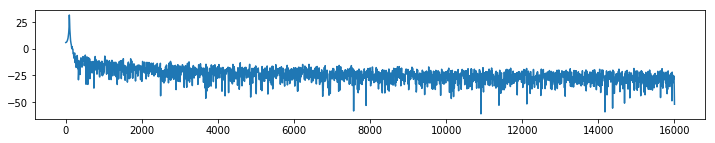

10.360105186113582

In [10]:
plt.figure(figsize=(12, 2))

y = f['tone_in_noise'][100]
sr = 32000

freq, pxx = util_stimuli.power_spectrum(y, sr)
plt.plot(freq, pxx)

plt.show()

import IPython.display as ipd

ipd.display(ipd.Audio(y, rate=sr))

util_stimuli.get_bandlimited_power(y, sr, band=[935.0, 1068.1])


In [11]:
f.close()